MobileNetV2 is a lightweight 53-layer deep CNN model with a smaller number of parameters and an input size of 224×224. It is based on the concept of depth-wise separable convolutions, which apply a single filter to each input channel and combine the output using point-wise convolutions.

# SECTION 1: BASIC TRANSFER LEARNING (No Augmentation/Callbacks)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

2025-09-25 16:56:38.313704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758819398.338523     520 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758819398.345995     520 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [3]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


In [4]:
# x_train = tf.image.resize(x_train, [224, 224])
# x_test = tf.image.resize(x_test, [224, 224])


In [5]:
# def resize_in_batches(images, target_size=(224, 224), batch_size=1000):
#     """Resize images in batches to avoid OOM errors"""
#     resized_images = []
    
#     for i in range(0, len(images), batch_size):
#         batch = images[i:i+batch_size]
#         resized_batch = tf.image.resize(batch, target_size)
#         resized_images.append(resized_batch.numpy())
        
#         # Clear GPU memory
#         tf.keras.backend.clear_session()
            
#     return np.concatenate(resized_images, axis=0)

In [6]:
# x_train_resized = resize_in_batches(x_train,batch_size=700)
# x_test_resized = resize_in_batches(x_test,batch_size=700)


In [7]:
def create_dataset_pipeline(x, y, batch_size=32, training=True):
    """Most memory-efficient approach - resize during training"""
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    
    if training:
        dataset = dataset.shuffle(1000)
    
    def resize_and_augment(image, label):
        # Resize on GPU during training
        image = tf.image.resize(image, [224, 224])
        if training:
            image = tf.image.random_flip_left_right(image)
        return image, label
    
    dataset = dataset.map(resize_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

batch_size = 16  # Small batch to save RAM

train_ds = create_dataset_pipeline(x_train, y_train, batch_size, training=True)
test_ds = create_dataset_pipeline(x_test, y_test, batch_size, training=False)

I0000 00:00:1758819406.271399     520 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758819406.272151     520 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [8]:
pretrained_base = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet' # load weights trained on ImageNet
)

In [9]:
pretrained_base.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [10]:
pretrained_base.trainable = False # freeze base model

In [11]:
pretrained_base.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
transfer_model = models.Sequential([
    pretrained_base,
    layers.GlobalAveragePooling2D(name='gap_tl'),
    layers.Dense(128, activation='relu', name='fc_tl'),
    layers.Dropout(0.5, name='dropout_tl'),
    layers.Dense(10, activation='softmax', name='output_tl')
])

In [13]:
transfer_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
transfer_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap_tl (GlobalAveragePooling2D) │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_tl (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_tl (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_tl (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
transfer_history = transfer_model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
        verbose=1
)

Epoch 1/10


I0000 00:00:1758819418.034602     572 service.cc:148] XLA service 0x784f94004420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758819418.034676     572 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758819418.034686     572 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758819418.981877     572 cuda_dnn.cc:529] Loaded cuDNN version 90300


   7/3125 ━━━━━━━━━━━━━━━━━━━━ 1:12 23ms/step - accuracy: 0.0403 - loss: 3.3623      

I0000 00:00:1758819422.831552     572 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 79s 21ms/step - accuracy: 0.6215 - loss: 1.0942 - val_accuracy: 0.7825 - val_loss: 0.6469
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 63s 20ms/step - accuracy: 0.7383 - loss: 0.7614 - val_accuracy: 0.7950 - val_loss: 0.5977
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 61s 20ms/step - accuracy: 0.7588 - loss: 0.7113 - val_accuracy: 0.8002 - val_loss: 0.5818
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 62s 20ms/step - accuracy: 0.7627 - loss: 0.6908 - val_accuracy: 0.8004 - val_loss: 0.5763
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 63s 20ms/step - accuracy: 0.7730 - loss: 0.6584 - val_accuracy: 0.8039 - val_loss: 0.5600
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 63s 20ms/step - accuracy: 0.7795 - loss: 0.6426 - val_accuracy: 0.8056 - val_loss: 0.5587
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 62s 20ms/step - accuracy: 0.7821 - loss: 0.6334 - val_accuracy: 0.8088 - val_loss: 0.5558
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 63s 20ms/step - accuracy: 0.7853 - loss: 0.62

In [16]:
def loss_acc_plots(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

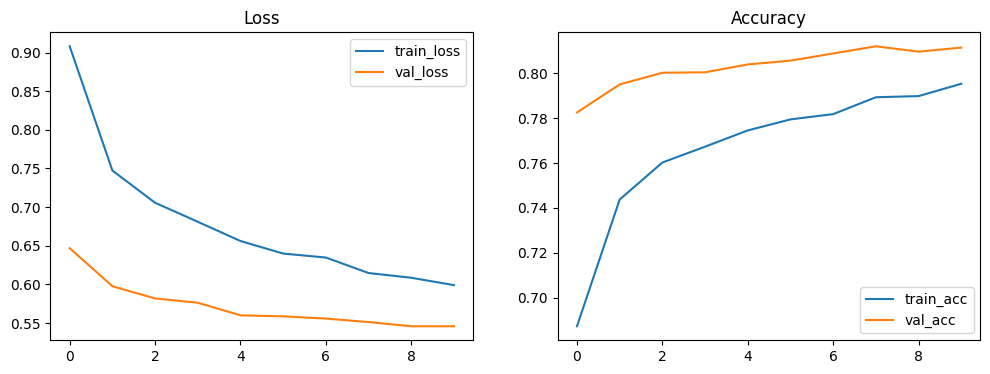

In [17]:
loss_acc_plots(transfer_history)

# SECTION 2: WITH DATA AUGMENTATION AND CALLBACKS


# SECTION 3: FINE-TUNING
